In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import gpytorch
import torch

# import GPDetectAnomaly and utils
from dipper.model_utils.GPDetectAnomaly import GPDetectAnomaly
from dipper.data_utils.utils import *
from dipper.model_utils.utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# Load data and inject an anomaly

/mnt/lustre/koa/koastore/sadow_group/personal/linneamw/research/dipper_detection/dipper-detection/dipper/data_utils/utils.py:186: RuntimeWarning: divide by zero encountered in divide
  y_err_binned = 1 / np.sqrt(np.array(var_binned))


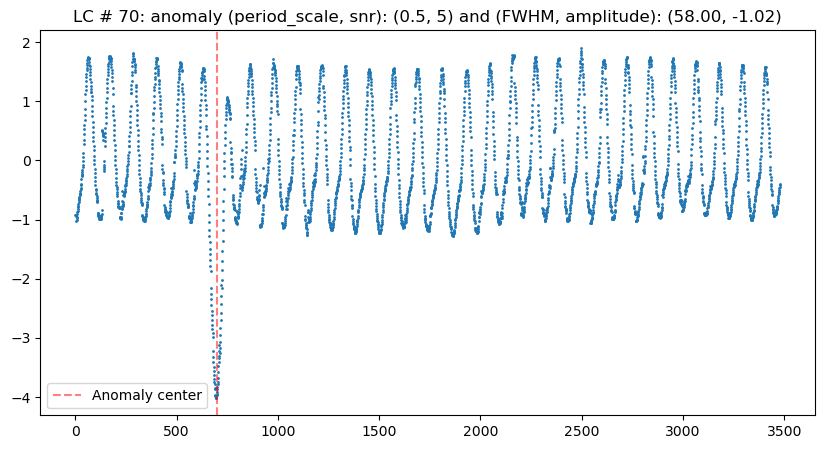

Anomaly locations:
[700]
15.802083333333332


In [2]:
# Data and anomaly parameters
file_number = 70
shape = "gaussian"
period_scale = 0.5
snr = 5
loc = 700

# Load the data
data_dir = '../data/k2/'
filename = f'k2_{file_number}.fits'
x, y, y_err = load_k2_data(data_dir + filename)

# Scale data to be between 0 and 1
y = (y - np.min(y)) / (np.max(y) - np.min(y))
y_err = y_err / (np.max(y) - np.min(y))

# Inject anomalies
steps, y, anomaly_locs, anomaly_amp, anomaly_fwhm = inject_anomaly(
    y, 
    num_anomalies=1, 
    seed=file_number, 
    shapes=[shape],
    period_scale=period_scale,
    snr=snr,
    anomaly_idx=[loc]
)

# Standardize data to have mean 0 and std of 1
mean_y = np.mean(y)
std_y = np.std(y)
y = (y - mean_y) / std_y
y_err = y_err / std_y

# Plot anomalies
plt.figure(figsize=(10,5))
plt.plot(range(len(x)), y, '.', markersize=2)
for i in range(len(anomaly_locs)):
    plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5, label='Anomaly center')
plt.legend()
plt.title(f"LC # {file_number}: anomaly (period_scale, snr): ({period_scale}, {snr}) and (FWHM, amplitude): ({anomaly_fwhm:.2f}, {anomaly_amp:.2f})")
plt.show()

# Print anomaly_locs, both indices and x[i]
print("Anomaly locations:")
print(anomaly_locs)
for i in anomaly_locs: print(x[int(i)])

# Anomaly detection with GP

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/likelihoods/noise_models.py:148: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.
  warnings.warn(
/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/dipper_detect/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


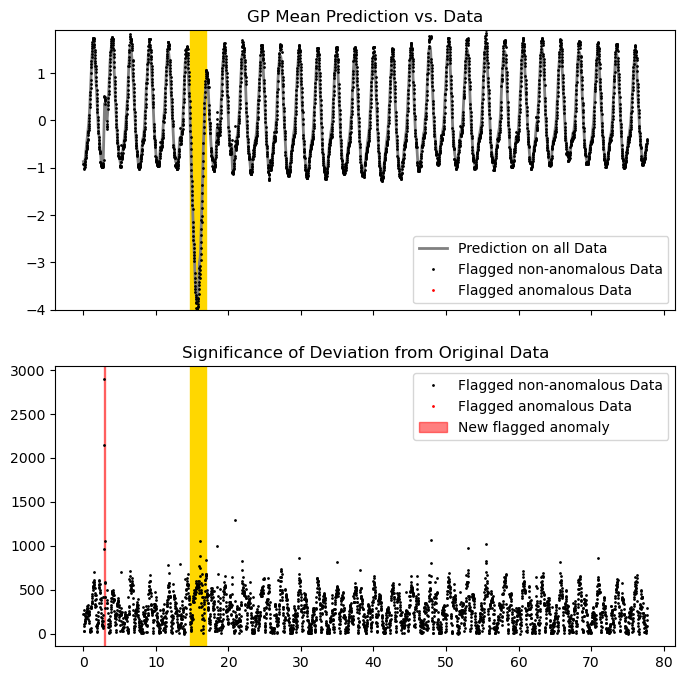

Anomalous edges = 121:144


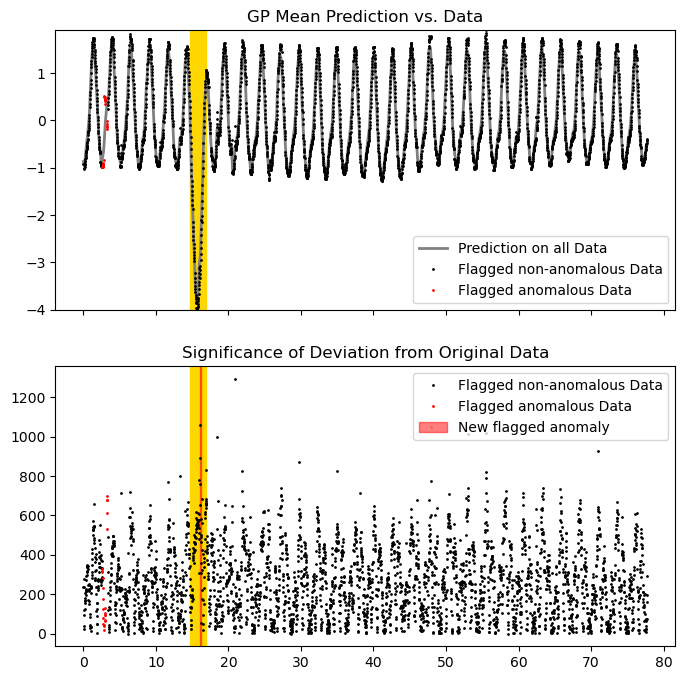

Anomalous edges = 705:722


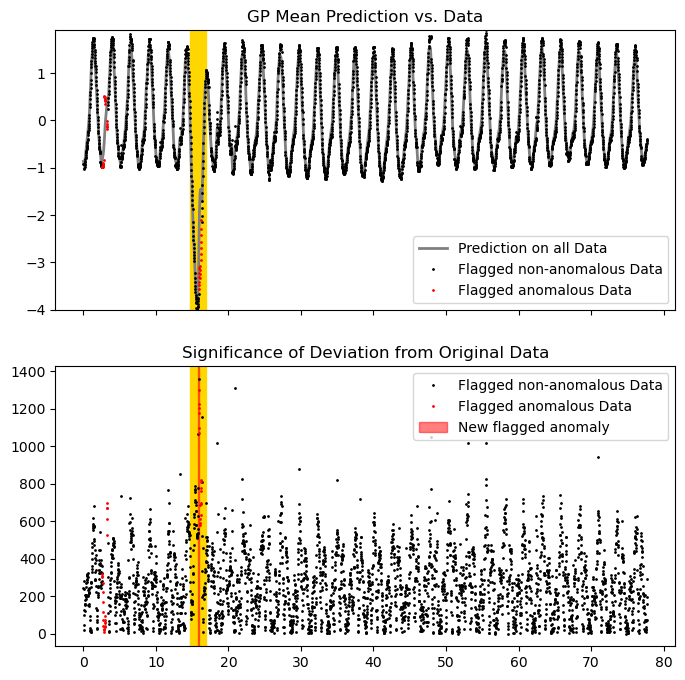

Anomalous edges = 684:725

 
 
 Predicting 
 
 



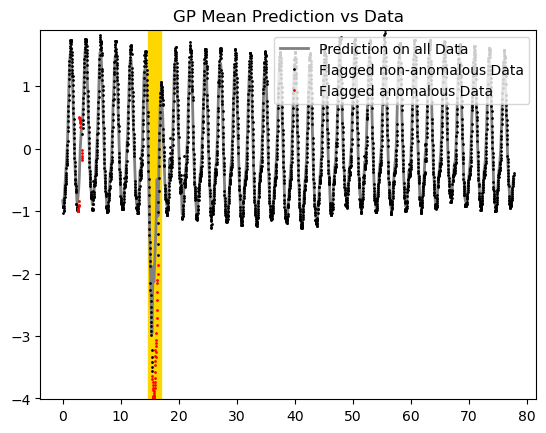

Injected anomaly centers: [700]
Anomalies identified: [1.]
Ratio of anomalies identified: 1.0


In [3]:
# Hyperparameters
which_metric = 'mll'
num_anomalies = 3
initial_lengthscale = 0.7
expansion_param = 3
training_iterations = 50
plot = True
detection_range = 50
min_contiguous = 10
len_deviant = 5

gp_detector = GPDetectAnomaly(
    x,
    y,
    y_err,
    which_metric=which_metric,
    num_anomalies=num_anomalies,
    initial_lengthscale=initial_lengthscale,
    expansion_param=expansion_param,
    len_deviant=len_deviant
)

gp_detector.detect_anomaly(
    training_iterations=training_iterations, 
    plot=plot,
    device=device,
    anomaly_locs=anomaly_locs,
    detection_range=detection_range
)

print(f"\n \n \n Predicting \n \n \n")
gp_detector.predict_anomaly(
    plot=plot,
    device=device,
    anomaly_locs=anomaly_locs,
    detection_range=detection_range,
    min_contiguous=min_contiguous
)

In [5]:
import pandas as pd

# Check identified anomalies
identified, identified_ratio = check_identified_anomalies(
    anomaly_locs, 
    gp_detector.anomalous, 
    detection_range,
    min_contiguous
)

print(f"Identified {identified} out of {len(anomaly_locs)} anomalies")

# Put results into a dictionary
column_names = [
    'filename', 
    'snr', 
    'period_scale', 
    'shape', 
    'location_idx', 
    'anomaly_amp', 
    'anomaly_fwhm', 
    'anomalous', 
    'detection_range', 
    'min_contiguous', 
    'identified', 
    'identified_ratio'
]

results = {
    'filename': filename, 
    'snr': snr, 
    'period_scale': period_scale, 
    'shape': shape,
    'location_idx': loc, 
    'anomaly_amp': anomaly_amp,
    'anomaly_fwhm': anomaly_fwhm,
    'anomalous': str(gp_detector.anomalous), 
    'detection_range': detection_range,
    'min_contiguous': min_contiguous,
    'identified': str(identified), 
    'identified_ratio': identified_ratio
}

# Convert results to a dataframe
gp_results = pd.DataFrame([results], columns=column_names)

# Write gp_results to results_dir
results_dir = '../results/'
results_filename = 'test_gp_saver'

# Append results to results file if it exists, else create it
try:
    existing_results = pd.read_csv(results_dir + results_filename + '.csv')
    gp_results = pd.concat([existing_results, gp_results], axis=0)
    gp_results.to_csv(results_dir + results_filename + '.csv', index=False)

except FileNotFoundError:
    gp_results.to_csv(results_dir + results_filename + '.csv', index=False)  

Identified [1.] out of 1 anomalies
